In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 
import logging as _logging

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

logger = _logging.getLogger()
logger.setLevel(_logging.DEBUG)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 7.5  # final time
rA = 1.5   # maximum interaction distance
#dim = 2
dim = 1
seed=67

dt = 0.05
t_data = [0,tf]

#force_names = ['cubic', 'pw. quad.', 'GLS']
force_names = ['cubic']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

# Adaptive time-stepping for two cells after proliferation

In [5]:
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]

In [6]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


Initial step cubic 0.022133523792153494
Stability bound estimate cubic 0.6757212492381401
Initial step cubic 0.009898412756172828
Stability bound estimate cubic 0.6851257071479225
Initial step cubic 0.0044267047584306985
Stability bound estimate cubic 0.4552102290056691
Initial step cubic 0.022120889351929914
Stability bound estimate cubic 0.5205779854277135
Initial step cubic 0.009892762462733311
Stability bound estimate cubic 0.534934036799769
Initial step cubic 0.0044241778703859825
Stability bound estimate cubic 0.37717320559091916


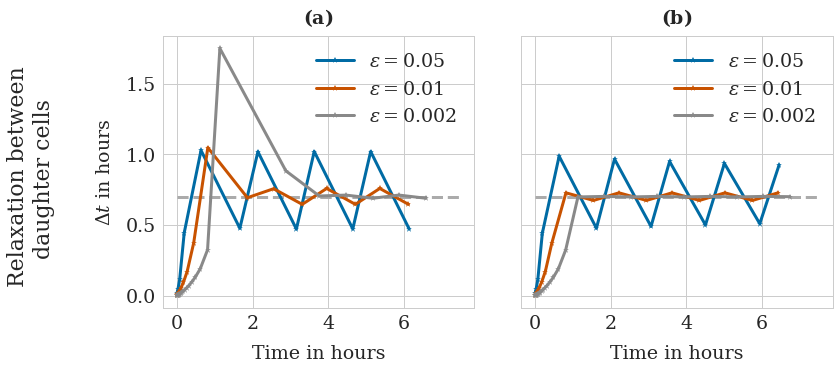

In [7]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

#ax1 No Jacobian - accuracy bound only
ax1.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=defcolors[2] )
#ax1.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#ax1.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

force = 'cubic'
epsilons = [0.05, 0.01, 0.002]

for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": eps,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    ax1.plot(ts[:-2], dts[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i])




ax1.legend()
ax1.set_title(r'$\bf{(a)}$')
ax1.set(xlabel='Time in hours')
ax1.set(ylabel='$\Delta t$ in hours')
#ax1.set(ylim=[-0.1, 1.2])
ax1.text(-4.5, 0.1, 'Relaxation between\n    daughter cells', fontsize=22, rotation='vertical')
#ax1.text(3.7, 1.45, '$\epsilon=0.01$', fontsize=22)

#ax2 Using the Jacobian to obtain the stability bound
ax2.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=defcolors[2])
#ax2.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#ax2.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')

    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True,'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ax2.plot(ts[:-2], dts[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i])

ax2.set_title(r'$\bf{(b)}$')
ax2.legend()
ax2.set(xlabel='Time in hours')
#ax2.set(ylabel='$\Delta t$ in hours')
#ax2.set(ylim=[-0.1, 1.2])
#ax2.text(3.4, 1.45, '$\epsilon=0.001$', fontsize=22)

plt.savefig('global_adap_relaxation.pdf', bbox_inches='tight')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

n_cells = len(cell_list)
for i in range(n_cells):
    #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
    ax1.add_patch(plt.Circle(cell_list[i].position ,0.5,color='blue', alpha=0.4))
    ax1.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color='blue')
    ax1.set_aspect('equal')
ax1.text(-1.8, -0.71, 'Relaxation between\n    daughter cells', fontsize=22, rotation='vertical')
ax1.set_title(r'$\bf{(a)}$')


n_cells = len(history[-1])
for i in range(n_cells):
    #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
    ax2.add_patch(plt.Circle(history[-1][i].position ,0.5,color='blue', alpha=0.4))
    ax2.plot(history[-1][i].position[0], history[-1][i].position[1], '.', color='blue')
    ax2.set_aspect('equal')
ax2.set_title(r'$\bf{(b)}$')

    
plt.savefig('relaxation_plot.pdf', bbox_inches='tight')

## Convergence study

In [ ]:
import scipy.interpolate as sci

In [ ]:
dt_ref = 0.00005
tf = 3.0

N_ref = int(1/dt_ref*tf)+1

t_data_ref, history = models_ef[force].simulate(
            cell_list,
            [0, tf],
            params[force],
            {'dt': dt_ref},
            raw_t=True,
        )

ref_traj = np.array(
            [
                [cell.position for cell in cell_list]
                for cell_list in history
            ]
        ) # (N_ref, n_cells, dim)

In [ ]:
from matplotlib import cm
import matplotlib.colors as mcolors

In [ ]:
eps_values = np.array([0.0001*1.25**n for n in range(0, 25)])
plt.figure()

sol = []

map_eps_values_to_unit_interval = [ np.log(10000*(x-np.min(range(0, 25))))/(np.max(range(0, 25))-np.min(range(0, 25)))/np.log(1.25) for x in eps_values]
colors = [ cm.jet(x) for x in map_eps_values_to_unit_interval ]


for i, eps in enumerate(eps_values):
    N = int(1/dt*tf) + 1
    
    t_data_sol, history = models_ef[force].simulate(
        cell_list,
        [0,tf],
        params[force],
        {'eps': eps, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]},
        raw_t=True,
    )

    traj = np.array([
        [cell.position for cell in cell_list]
        for cell_list in history
    ]) # (N, n_cells, dim)
    
    
    
    interp = sci.interp1d(
        t_data_sol, traj,
        axis=0,
        bounds_error=False, kind='cubic',
        fill_value=tuple(traj[[0, -1], :, :])
    )(t_data_ref[:])
    error = (
        np.linalg.norm(
            interp - ref_traj,
            axis=0)
        /np.linalg.norm(
            ref_traj,
            axis=0)
    ).mean(axis=0)
    
    plt.plot(t_data_ref, np.abs((interp[:, 1, 0] - interp[:, 0,0])  - (ref_traj[:, 1, 0]-ref_traj[:,0,0])), color=colors[i])
    plt.xlabel('Time $t$ in hours')
    plt.ylabel('$|y_{eps}-y_{ref}|$')
    #plt.legend()
    


    sol.append(error)
cma = mcolors.ListedColormap(colors, name='from_list', N=None) # creation of a user cmap
msm = cm.ScalarMappable(cmap=cma) 
msm.set_array(eps_values) 
cbar = plt.colorbar(msm)
cbar.set_label('$\epsilon$', rotation=90)

In [ ]:
plt.loglog(eps_values, sol, '-*')
plt.loglog(eps_values[1:-2], eps_values[1:-2]**0.5*0.5, ':',
           label='$f(\epsilon)= \sqrt{\epsilon}$', color='grey')
plt.xlabel('$\epsilon$')
plt.ylabel('$|y_{eps}-y_{ref}|/|y_{ref}|$')
plt.legend()


In [ ]:
plt.plot()

In [ ]:
eps_values